In [3]:
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                                 cartopy_ylim, latlon_coords)
import shapely.geometry as sgeom
# from matplotlib.cm import get_cmap
# import sys
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pathlib as pl

In [5]:
ds = xr.open_dataset("../geog/geo_em.d01.nc")
xlat0 = ds.XLAT_M.isel(Time=0)
xlong0 = ds.XLONG_M.isel(Time=0)

#xlong0 = xlong0.drop("TIME")
#xlat0 = xlat0.drop("XTIME")
# ds = ds.drop(["XLAT","XLONG"])
# ds = ds.assign_coords(dict(XLAT = xlat0, XLONG = xlong0))

In [6]:
# example_file = Dataset("./geog/geo_em.d01.nc")
# hgt = getvar(example_file, "ter")
# lats, lons = latlon_coords(hgt)
# cart_proj = get_cartopy(hgt)
# cart_proj.proj4_params

In [20]:
shp_files_east = "/home/wrudisill/scratch/EastLSM_Only/shpfiles/EastRiver_Shapefile.shp"
shp_files_custom =  "/home/wrudisill/scratch/EastLSM_Only/shpfiles/custom_area.shp"

In [21]:
shape_feature = ShapelyFeature(Reader(shp_files_east).geometries(),
                                       crs=crs.PlateCarree(), 
                                       facecolor='none',
                                       edgecolor='black')

east_geom = [x for x in shape_feature.geometries()][0]

In [22]:
latr=xlat0.values.reshape(-1)
lonr=xlong0.values.reshape(-1)
veclen = len(lonr)



In [23]:
def return_mask(geom):
    keep_array = np.zeros(veclen)
    for i in range(veclen):
        pt=sgeom.Point(lonr[i], latr[i])
        if geom.contains(pt):
            keep_array[i] = True
        else:
            keep_array[i] = False
    keep_array_sq = keep_array.reshape(xlat0.values.shape)
    return keep_array_sq

In [24]:
east_mask = return_mask(east_geom)


In [25]:
east_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
ds["EAST_MASK"] = ds["HGT_M"]

In [27]:
ds["EAST_MASK"].values = east_mask[np.newaxis, :,:]

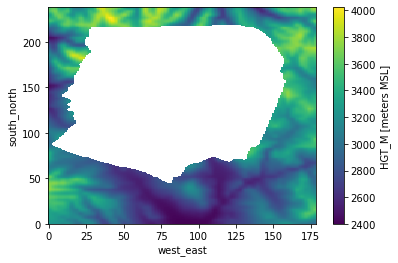

In [28]:
ds.where(ds["EAST_MASK"] == 0).HGT_M.plot()

In [58]:
dem=xr.open_dataset("ASO_DEM_3m-to500m_regrid_to_wrfin.nc")

In [62]:
dem.isel(band=0)

<xarray.Dataset>
Dimensions:                        (south_north: 99, west_east: 74)
Coordinates:
    band                           int64 1
    lon                            (south_north, west_east) float32 -107.1362 ... -106.71448
    lat                            (south_north, west_east) float32 38.657455 ... 39.098186
Dimensions without coordinates: south_north, west_east
Data variables:
    __xarray_dataarray_variable__  (south_north, west_east) float64 0.0 ... 0.0

In [63]:
dem = dem.rename(dict(__xarray_dataarray_variable__="HGT_M"))

In [79]:
dem.to_netcdf("ASO_DEM_3m-to500m_regrid_to_wrfin0.nc")

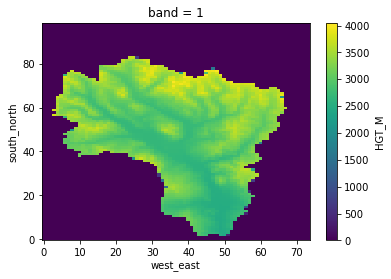

In [65]:
dem.HGT_M.plot()

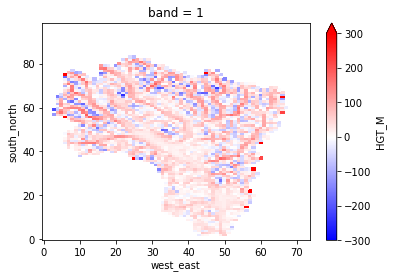

In [70]:
(ds.where(ds["EAST_MASK"] == 1).HGT_M - dem.HGT_M).plot(vmin=-300,vmax=300, cmap='bwr')

In [77]:
ds[["HGT_M", "EAST_MASK"]].to_netcdf("geo_em_with_EastMask.nc")